# Tanzanian Water Wells

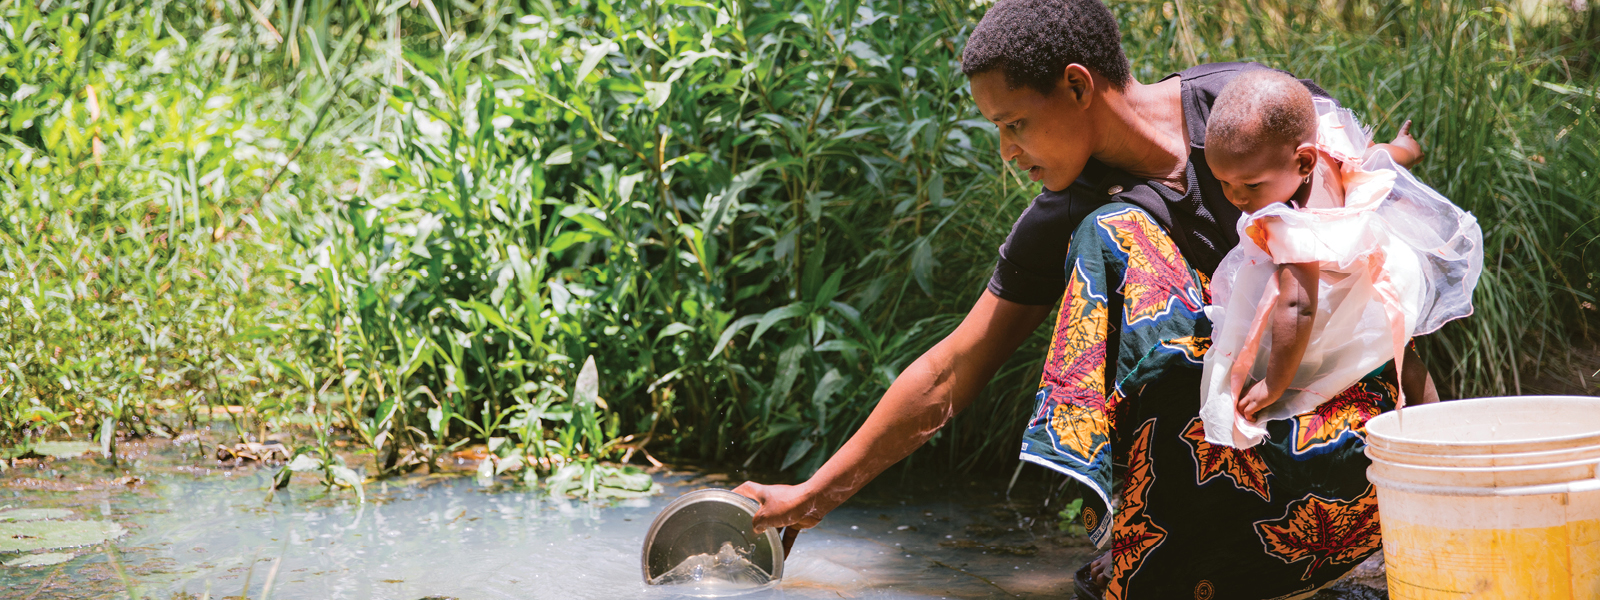

# Overveiw


This project analyzes water wells in Tanzania to help out Humanitarian Relief Co. The Humanitarian Relief Co. (HRC) wants us to create a model that can accurately predict if a water well is functioning or not. In the dataset we analyzed, there were over 55,000 water wells with over 50 features describing each individual water well. We narrowed down some of the data so that there would be less noise in our model. We made six different predictive models and then chose our best model. Our best resullts came from an XG Boost which allowed us to make predictions for those wells. Our goal is to reduce the amount of technicians sent to fix wells.

## Business Problem

We have been hired by the Humanitarian Relief Co. to help them create a model that can accurately predict if a water well is functioning or not. They want to optimize their use of technicians and send them to the water wells that need repair the most.

- Be able to predict if waterwell is functional or not. Explore important metrics that can be used as things to make a water well last longer
- Focus on getting water to everyone

**Context**
- False-Positive - Predict functional well when its not (reduce)
- False-Negative - Predict non-functional when it is (reduce but not as important)
- Would rather say a well is not functional and is versus functional and is not.
- Put 'needs work' wells with non-functional wells. To turn into binary classification

**Evaluation**
- Accuracy - balances the two kinds of errors (but is impractical with imbalanced targets)
- **Precision** - helps reduce false positives
- Recall - helps reduce false negatives
- **F1-Score** - balances recall & precision (and is better than accuracy with imbalanced targets)
- **ROC-AUC** - helps focus on better probability outputs (makes sure our predicted probabilities are better)

**Getting our imports and reading in our data**

In [2]:
import pandas as pd

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer

In [4]:
df = pd.read_csv('data/features.csv')

In [5]:
target = pd.read_csv('data/target.csv')

In [6]:
print(df.shape)
print(target.shape)

(59400, 40)
(59400, 2)


In [7]:
pd.set_option('display.max_columns', None)

## Data Exploration

- explore null values, reduce variables

In [8]:
data = df.merge(target, on=['id'])

In [9]:
data.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [11]:
data.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

- Lots of object types, not a lot of floats
- Explore the null values
    - Important? Valuable?
- Explore variables with shared name
    - Duplicate information?
- Attempt to clean and reduce columns used

In [12]:
data['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

**Data seems balanced**
- Will group needs repair with non-functional to follow our business problem

## Data Understanding
- Explore our data and drop coolumns

**Get rid of waterpoint_types and keep waterpoint_type_groups**
- We get a more general idea with type groups

In [13]:
data['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [14]:
data['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

**Drop scheme_name, we could still use scheme_management**
- Too many uniques in scheme_name
- Scheme management better groups the values

In [15]:
data['scheme_name'].value_counts()

K                          682
None                       644
Borehole                   546
Chalinze wate              405
M                          400
                          ... 
Nameqhuwadiba                1
BL Bonifas Kingu             1
Mabatini                     1
Namasakata Water Supply      1
Lu                           1
Name: scheme_name, Length: 2696, dtype: int64

In [16]:
data['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

**Drop funder and installer**
- Values seem irrelevant to our problem
- Does not add any helpful info


In [17]:
data['funder'].nunique()

1897

In [18]:
data['funder'].value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Regina Group                 1
Mbozi Hospital               1
Rhobi Wambura                1
Othod                        1
Kanisani                     1
Name: funder, Length: 1897, dtype: int64

In [19]:
data['installer'].nunique()

2145

**Possibly drop village and codes in favor of latitude and longitude**

In [20]:
data['subvillage'].value_counts()

Madukani           508
Shuleni            506
Majengo            502
Kati               373
Mtakuja            262
                  ... 
Hihina               1
Mkisha               1
Kigangi              1
Nyabusalu No. 7      1
Kwalambua            1
Name: subvillage, Length: 19287, dtype: int64

**DROP, NOT USEFUL**

In [21]:
data['num_private'].value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

In [22]:
data['permit'].value_counts(normalize=True)

True     0.68955
False    0.31045
Name: permit, dtype: float64

**Probably keep extraction_type_class instead of extraction_type/group**

In [23]:
data['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [24]:
data['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [25]:
data['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [26]:
location = data[['region',                       
'region_code',                  
'district_code',                
'lga', 
'ward']]

**Keep region drop everything else location wise**
- regions would give us a good understanding for location of wells
- better oragnized

In [27]:
[print(x,'\n*'*2, data[x].value_counts()) for x in location]

region 
*
* Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64
region_code 
*
* 11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64
district_code 
*
* 1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43

[None, None, None, None, None]

In [28]:
data['wpt_name'].value_counts()

none                  3563
Shuleni               1748
Zahanati               830
Msikitini              535
Kanisani               323
                      ... 
Kwa Fundi Ally           1
Kwamuumbila              1
Zahanati Kwa Meta        1
Kwa Veronika Senga       1
Kwa Crspini Mbuya        1
Name: wpt_name, Length: 37400, dtype: int64

### Cleaning Insights

- too many values in certain columns, a bunch of one-time values
- got rid of columns that shared same vales (extraction, codes, management)
- got rid of irrelevant data (id, permit, num_private)\
- installer/scheme management had lots of values with some being one-shots and lots of nulls

In [29]:
drop = ['id', 'waterpoint_type', 'scheme_name', 'funder', 
        'num_private', 'permit', 'extraction_type', 'extraction_type_group',
        'region_code','district_code','lga','ward', 'recorded_by', 'public_meeting', 
        'scheme_management', 'installer', 'payment', 'subvillage']

## Further exploring after dropping cols
- Explore the 'water well' values more
- source, quality, etc

In [30]:
data.drop(columns=drop).head()

,amount_tsh,date_recorded,gps_height,longitude,latitude,wpt_name,basin,region,population,construction_year,extraction_type_class,management,management_group,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type_group,status_group
0,6000.0,2011-03-14,1390,34.938093,-9.856322,none,Lake Nyasa,Iringa,109,1999,gravity,vwc,user-group,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,functional
1,0.0,2013-03-06,1399,34.698766,-2.147466,Zahanati,Lake Victoria,Mara,280,2010,gravity,wug,user-group,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,functional
2,25.0,2013-02-25,686,37.460664,-3.821329,Kwa Mahundi,Pangani,Manyara,250,2009,gravity,vwc,user-group,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe,functional
3,0.0,2013-01-28,263,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mtwara,58,1986,submersible,vwc,user-group,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe,non functional
4,0.0,2011-07-13,0,31.130847,-1.825359,Shuleni,Lake Victoria,Kagera,0,0,gravity,other,other,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,functional


In [31]:
clean_data = data.drop(columns=drop)

In [32]:
clean_data.isna().sum()

amount_tsh               0
date_recorded            0
gps_height               0
longitude                0
latitude                 0
wpt_name                 0
basin                    0
region                   0
population               0
construction_year        0
extraction_type_class    0
management               0
management_group         0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type_group    0
status_group             0
dtype: int64

In [33]:
data['population'].value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

**Making a new colum indicating if a population is near well or not**

In [34]:
near_pop = []
for x in list(clean_data['population'].values):
    if x == 0:
        near_pop.append(False)
    else:
        near_pop.append(True)

In [35]:
clean_data['near_pop'] = near_pop

In [36]:
clean_data.head()

,amount_tsh,date_recorded,gps_height,longitude,latitude,wpt_name,basin,region,population,construction_year,extraction_type_class,management,management_group,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type_group,status_group,near_pop
0,6000.0,2011-03-14,1390,34.938093,-9.856322,none,Lake Nyasa,Iringa,109,1999,gravity,vwc,user-group,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,functional,True
1,0.0,2013-03-06,1399,34.698766,-2.147466,Zahanati,Lake Victoria,Mara,280,2010,gravity,wug,user-group,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,functional,True
2,25.0,2013-02-25,686,37.460664,-3.821329,Kwa Mahundi,Pangani,Manyara,250,2009,gravity,vwc,user-group,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe,functional,True
3,0.0,2013-01-28,263,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mtwara,58,1986,submersible,vwc,user-group,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe,non functional,True
4,0.0,2011-07-13,0,31.130847,-1.825359,Shuleni,Lake Victoria,Kagera,0,0,gravity,other,other,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,functional,False


**Keep basin, seems useful and organized**

In [37]:
clean_data['basin'].value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

**exlpore our water data**

In [38]:
clean_data[['water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class']].head(25)

,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class
0,soft,good,enough,enough,spring,spring,groundwater
1,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface
2,soft,good,enough,enough,dam,dam,surface
3,soft,good,dry,dry,machine dbh,borehole,groundwater
4,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface
5,salty,salty,enough,enough,other,other,unknown
6,soft,good,enough,enough,machine dbh,borehole,groundwater
7,milky,milky,enough,enough,shallow well,shallow well,groundwater
8,salty,salty,seasonal,seasonal,machine dbh,borehole,groundwater
9,soft,good,enough,enough,shallow well,shallow well,groundwater


In [39]:
clean_data['water_quality'].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [40]:
clean_data['quantity_group'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [41]:
clean_data['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [42]:
clean_data['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [43]:
clean_data['source_class'].value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

### Cleaning Insights

- too many values in wpt_name, a bunch of one-time values
- got rid of columns that shared same values (quantity, source, etc)
- favored region for location data vs lat/long

In [44]:
clean_drop = ['wpt_name', 'water_quality', 'quantity', 'source', 'date_recorded', 'longitude', 'latitude']

## Cleaning up final data

- explore what the remaining values actaully mean, domain expertise

In [45]:
final_data = clean_data.drop(columns=clean_drop)

In [46]:
for x in final_data:
    display(x,'******',final_data[x].value_counts())

'amount_tsh'

'******'

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

'gps_height'

'******'

 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64

'basin'

'******'

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

'region'

'******'

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

'population'

'******'

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

'construction_year'

'******'

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

'extraction_type_class'

'******'

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

'management'

'******'

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

'management_group'

'******'

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

'payment_type'

'******'

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

'quality_group'

'******'

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

'quantity_group'

'******'

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

'source_type'

'******'

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

'source_class'

'******'

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

'waterpoint_type_group'

'******'

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

'status_group'

'******'

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

'near_pop'

'******'

True     38019
False    21381
Name: near_pop, dtype: int64

In [47]:
final_data[['amount_tsh', 'gps_height', 'construction_year', 'population']]

,amount_tsh,gps_height,construction_year,population
0,6000.0,1390,1999,109
1,0.0,1399,2010,280
2,25.0,686,2009,250
3,0.0,263,1986,58
4,0.0,0,0,0
...,...,...,...,...
59395,10.0,1210,1999,125
59396,4700.0,1212,1996,56
59397,0.0,0,0,0
59398,0.0,0,0,0


### amount_tsh 
- Total static head (amount water available to waterpoint)
- The static head, the amount of water in a well when the well is "at rest" - that is, no one has pumped water out of the well for some time and the well has filled back up as much as it's going to
- Make indicator column if there is static water or not

### population
- population amount near water well
- make an indicator column if there is a population near or not

### gps_height
- Altitude of the well
- make column indicator if it above or below ground level or at ground level
- Water levels in wells are usually reported as depths below land surface, although the measuring point can be any convenient fixed place near the top of the well. In this drawing the measuring point is the top of the casing. The altitude of the measuring point is commonly recorded so that static water levels can also be reported as altitudes.

### contruction year
- year it was constructed 
- can probably make an indicator column if it has one or not
- furthermore could make insights on dates we do have (older wells, recent wells...)

**sources**


https://mbmggwic.mtech.edu/sqlserver/v11/help/welldesign.asp


https://inspectapedia.com/water/Well_Static_Head_Definition.php#:~:text=The%20static%20head%2C%20the%20amount,dry%20season%20of%20the%20year

In [48]:
final_data.head()

,amount_tsh,gps_height,basin,region,population,construction_year,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,status_group,near_pop
0,6000.0,1390,Lake Nyasa,Iringa,109,1999,gravity,vwc,user-group,annually,good,enough,spring,groundwater,communal standpipe,functional,True
1,0.0,1399,Lake Victoria,Mara,280,2010,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional,True
2,25.0,686,Pangani,Manyara,250,2009,gravity,vwc,user-group,per bucket,good,enough,dam,surface,communal standpipe,functional,True
3,0.0,263,Ruvuma / Southern Coast,Mtwara,58,1986,submersible,vwc,user-group,never pay,good,dry,borehole,groundwater,communal standpipe,non functional,True
4,0.0,0,Lake Victoria,Kagera,0,0,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional,False


In [49]:
final_data['gps_height'].value_counts()

 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64

In [50]:
final_data[['gps_height', 'amount_tsh']]

,gps_height,amount_tsh
0,1390,6000.0
1,1399,0.0
2,686,25.0
3,263,0.0
4,0,0.0
...,...,...
59395,1210,10.0
59396,1212,4700.0
59397,0,0.0
59398,0,0.0


In [51]:
lvl = []
for x in list(final_data['gps_height'].values):
    if x == 0:
        lvl.append('level')
    elif x > 0:
        lvl.append('above')
    else:
        lvl.append('below')

In [52]:
final_data['level'] = lvl

In [53]:
stwater = []

for x in list(final_data['amount_tsh'].values):
    if x == 0:
        stwater.append(False)
    else:
        stwater.append(True)

In [54]:
final_data['has_static'] = stwater

In [55]:
year = []

for x in list(final_data['construction_year'].values):
    if x == 0:
        year.append(False)
    else:
        year.append(True)

In [56]:
final_data['has_year'] = year

In [57]:
final_data['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

**Following our business problem**
- grouping non functional and needs work

In [58]:
final_data['status_group'] = final_data["status_group"].replace("functional needs repair", "non functional")

In [59]:
final_data['status_group'].value_counts()

functional        32259
non functional    27141
Name: status_group, dtype: int64

In [60]:
final_data.head()

,amount_tsh,gps_height,basin,region,population,construction_year,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,status_group,near_pop,level,has_static,has_year
0,6000.0,1390,Lake Nyasa,Iringa,109,1999,gravity,vwc,user-group,annually,good,enough,spring,groundwater,communal standpipe,functional,True,above,True,True
1,0.0,1399,Lake Victoria,Mara,280,2010,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional,True,above,False,True
2,25.0,686,Pangani,Manyara,250,2009,gravity,vwc,user-group,per bucket,good,enough,dam,surface,communal standpipe,functional,True,above,True,True
3,0.0,263,Ruvuma / Southern Coast,Mtwara,58,1986,submersible,vwc,user-group,never pay,good,dry,borehole,groundwater,communal standpipe,non functional,True,above,False,True
4,0.0,0,Lake Victoria,Kagera,0,0,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional,False,level,False,False


In [61]:
final_data['status_group'] = final_data["status_group"].replace("non functional", "non functional/needs repair")

In [62]:
final_data.head()

,amount_tsh,gps_height,basin,region,population,construction_year,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,status_group,near_pop,level,has_static,has_year
0,6000.0,1390,Lake Nyasa,Iringa,109,1999,gravity,vwc,user-group,annually,good,enough,spring,groundwater,communal standpipe,functional,True,above,True,True
1,0.0,1399,Lake Victoria,Mara,280,2010,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional,True,above,False,True
2,25.0,686,Pangani,Manyara,250,2009,gravity,vwc,user-group,per bucket,good,enough,dam,surface,communal standpipe,functional,True,above,True,True
3,0.0,263,Ruvuma / Southern Coast,Mtwara,58,1986,submersible,vwc,user-group,never pay,good,dry,borehole,groundwater,communal standpipe,non functional/needs repair,True,above,False,True
4,0.0,0,Lake Victoria,Kagera,0,0,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional,False,level,False,False


**Save as csv to be able to use for modeling**

In [63]:
#final_data.to_csv('../../data/clean_wells.csv')

In [64]:
data = pd.read_csv('data/clean_wells.csv')

In [65]:
data = data.drop(columns='Unnamed: 0')

In [66]:
data.head()

,amount_tsh,gps_height,basin,region,population,construction_year,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,status_group,near_pop,level,has_static,has_year
0,6000.0,1390,Lake Nyasa,Iringa,109,1999,gravity,vwc,user-group,annually,good,enough,spring,groundwater,communal standpipe,functional,True,above,True,True
1,0.0,1399,Lake Victoria,Mara,280,2010,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional,True,above,False,True
2,25.0,686,Pangani,Manyara,250,2009,gravity,vwc,user-group,per bucket,good,enough,dam,surface,communal standpipe,functional,True,above,True,True
3,0.0,263,Ruvuma / Southern Coast,Mtwara,58,1986,submersible,vwc,user-group,never pay,good,dry,borehole,groundwater,communal standpipe,non functional/needs repair,True,above,False,True
4,0.0,0,Lake Victoria,Kagera,0,0,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional,False,level,False,False


# Modeling Time

- Try models out
- Pick the best one and explore hyper-parameters


**Baseline Model**
- If we were to predict functional all the time, we would be right 54% of the time
- Beat 54% accuracy

In [67]:
data['status_group'].value_counts(normalize=True)

functional                     0.543081
non functional/needs repair    0.456919
Name: status_group, dtype: float64

**Train Test Split**

In [68]:
X = data.drop(columns = ['status_group', 'amount_tsh', 'gps_height', 'population', 'construction_year', 'has_year'])
y = data['status_group']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [69]:
y_map = {'functional': 1, 'non functional/needs repair':0}
y_train_fix = y_train.map(y_map)


In [70]:
y_test_fix = y_test.map(y_map)

- creating a seperate cat cols and num cols
- scaling and ohe
- creating pipeline to make models

In [74]:
X.head(3)

,basin,region,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,near_pop,level,has_static
0,Lake Nyasa,Iringa,gravity,vwc,user-group,annually,good,enough,spring,groundwater,communal standpipe,True,above,True
1,Lake Victoria,Mara,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,True,above,False
2,Pangani,Manyara,gravity,vwc,user-group,per bucket,good,enough,dam,surface,communal standpipe,True,above,True


In [75]:
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

In [76]:
cat_cols

Index(['basin', 'region', 'extraction_type_class', 'management',
       'management_group', 'payment_type', 'quality_group', 'quantity_group',
       'source_type', 'source_class', 'waterpoint_type_group', 'level'],
      dtype='object')

In [77]:
num_cols

Index(['near_pop', 'has_static'], dtype='object')

In [80]:
num_trans = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])
cat_trans = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                          sparse=False))
])

In [84]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_trans, num_cols),
    ('cat', cat_trans, cat_cols)
])

In [85]:
preprocessor.fit(X_train)
X_tr_pr = preprocessor.transform(X_train)
X_te_pr = preprocessor.transform(X_test)

## Random Forest

In [153]:
rfc = RandomForestClassifier(random_state=42, n_estimators=150, max_depth=30, min_samples_leaf=7)
rfc.fit(X_tr_pr, y_train_fix)

rfc_scores = cross_val_score(estimator=rfc, X=X_tr_pr, y=y_train_fix, cv=5)

print(f"Train Median score: {np.median(rfc_scores):.4f} (+/- {np.std(rfc_scores):.4f})")
print('Test Score:',rfc.score(X_te_pr, y_test_fix))

Train Median score: 0.7734 (+/- 0.0083)
Test Score: 0.7744107744107744


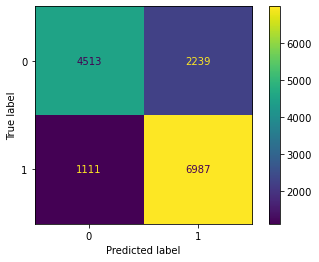

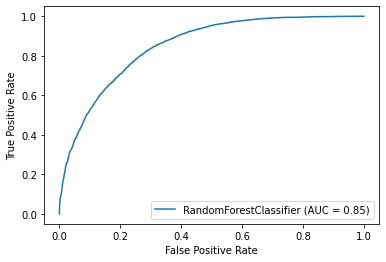

In [154]:
plot_confusion_matrix(rfc, X_te_pr, y_test_fix);
plot_roc_curve(rfc, X_te_pr, y_test_fix)

## Decision Tree Model

In [155]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_tr_pr, y_train_fix)

dt_scores_cv = cross_val_score(dt, X_tr_pr, y_train_fix, cv=5)

print(f"Median Train score: {np.median(dt_scores_cv):.4f} (+/- {np.std(dt_scores_cv):.4f})")

print('Test Score:', dt.score(X_te_pr, y_test_fix))

Median Train score: 0.7751 (+/- 0.0075)
Test Score: 0.774074074074074


In [156]:
dt.predict(X_te_pr)

array([0, 1, 1, ..., 0, 1, 0], dtype=int64)

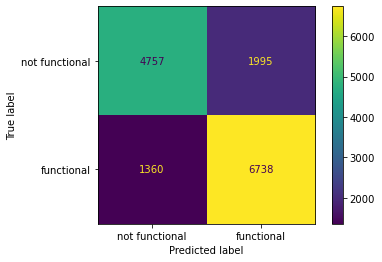

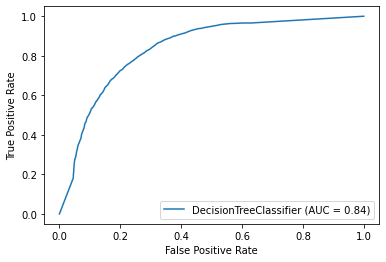

In [157]:
plot_confusion_matrix(dt, X_te_pr, y_test_fix, display_labels=['not functional', 'functional']);
plot_roc_curve(dt, X_te_pr, y_test_fix)

## XGBoost Model

- We input our hyper-parameters after running a grid search

In [86]:
xgb_model = xgb.XGBClassifier(random_state=42, learning_rate=.25, 
                              max_depth=12, n_estimators=75)

xgb_model.fit(X_tr_pr, y_train_fix)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=75, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [87]:
print(f"Train Score: {xgb_model.score(X_tr_pr, y_train_fix)}")
print(f"Test Score: {xgb_model.score(X_te_pr, y_test_fix)}")

Train Score: 0.8197755331088664
Test Score: 0.7820202020202021


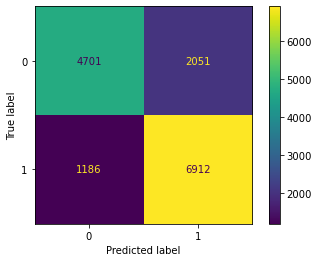

In [88]:
plot_confusion_matrix(xgb_model, X_te_pr, y_test_fix);

## Exploring Thresholding
- Adjusting how much leeway our model has when predicting our target varaibles
- By adjusting the models' threshold, we can get a better precision score without sacrificing the other scores too much
- We want to reduce our false-positves to better align with our business model

In [89]:
train_probs = xgb_model.predict_proba(X_tr_pr)[:,1]
test_probs = xgb_model.predict_proba(X_te_pr)[:,1]

In [90]:
train_preds = xgb_model.predict(X_tr_pr)
test_preds = xgb_model.predict(X_te_pr)

In [93]:
col_names = ['threshold', 'mean_train_pred', 'mean_test_pred', 'train_acc', 'test_acc', 
             'train_prec', 'test_prec', 'train_rec', 'test_rec', 'train_f1', 'test_f1']
metrics_df = pd.DataFrame(columns=col_names)

for x in np.arange(train_probs.min(), train_probs.max(), 0.01):
    threshold = x
    
    y_pred_train = np.where(train_probs > x, 1, 0)
    y_pred_test = np.where(test_probs > x, 1, 0)
    
    train_acc = accuracy_score(y_train_fix, y_pred_train)
    test_acc = accuracy_score(y_test_fix, y_pred_test)
    
    train_prec = precision_score(y_train_fix, y_pred_train)
    test_prec = precision_score(y_test_fix, y_pred_test)
    
    train_rec = recall_score(y_train_fix, y_pred_train)
    test_rec = recall_score(y_test_fix, y_pred_test)
    
    train_f1 = f1_score(y_train_fix, y_pred_train)
    test_f1 = f1_score(y_test_fix, y_pred_test)
    
    placeholder = [threshold, y_pred_train.mean(), y_pred_test.mean(),
                   train_acc, test_acc, train_prec, test_prec,
                   train_rec, test_rec, train_f1, test_f1]
    
    sample_S = pd.Series(placeholder, index=col_names)
    metrics_df = metrics_df.append(sample_S, ignore_index=True)

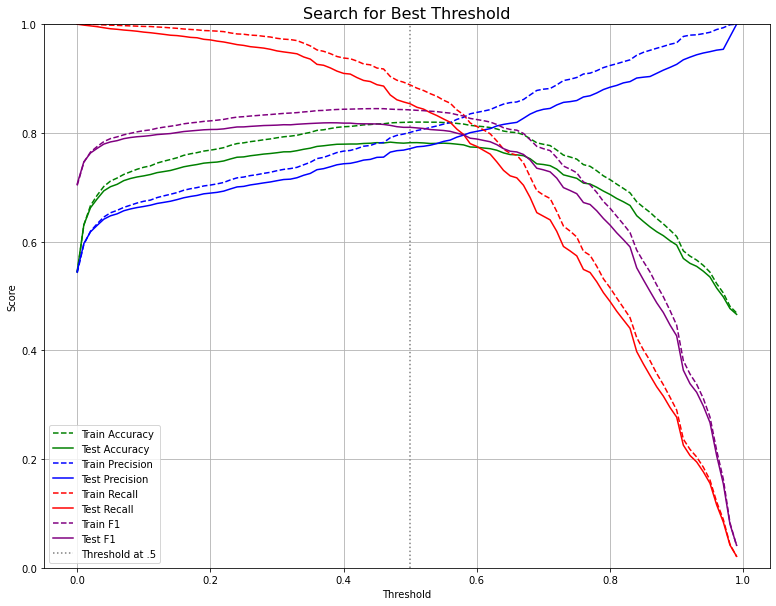

In [94]:
fig, ax = plt.subplots(figsize=(13, 10))
ax.set_title("Search for Best Threshold", fontsize=16)

ax.set_xlabel("Threshold")
ax.set_ylabel("Score")
ax.grid(True)

ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = metrics_df['threshold'].values

# Currently have all the train metrics hashed out - can unhash to visualize

ax.plot(X_axis, metrics_df['train_acc'], ls='--', color='g', label='Train Accuracy')
ax.plot(X_axis, metrics_df['test_acc'], color='g', label='Test Accuracy')

ax.plot(X_axis, metrics_df['train_prec'], ls='--', color='b', label='Train Precision')
ax.plot(X_axis, metrics_df['test_prec'], color='b', label='Test Precision')

ax.plot(X_axis, metrics_df['train_rec'], ls='--', color='r', label='Train Recall')
ax.plot(X_axis, metrics_df['test_rec'], ls='-', color='r', label='Test Recall')

ax.plot(X_axis, metrics_df['train_f1'], ls='--', color='purple', label='Train F1')
ax.plot(X_axis, metrics_df['test_f1'], ls='-', color='purple', label='Test F1')

ax.vlines(.5, 0, 1, color='gray', ls='dotted', label='Threshold at .5')

plt.legend()
plt.show()

In [143]:
adj_train_preds = np.where(train_probs > .72, 1, 0)
adj_test_preds = np.where(test_probs > .72, 1, 0)

In [144]:
confusion_matrix(y_train_fix, adj_train_preds)

array([[18375,  2014],
       [ 8259, 15902]], dtype=int64)

In [145]:
confusion_matrix(y_test_fix, adj_test_preds)

array([[5866,  886],
       [3069, 5029]], dtype=int64)

In [146]:
# Now evaluate:
print(f"Old Train F1: {f1_score(y_train_fix, train_preds)}")
print(f"Old Test F1: {f1_score(y_test_fix, test_preds)}")
print("*"*20)
print(f"New Train F1: {f1_score(y_train_fix, adj_train_preds)}")
print(f"New Test F1: {f1_score(y_test_fix, adj_test_preds)}")

Old Train F1: 0.842417224392063
Old Test F1: 0.810269034640408
********************
New Train F1: 0.7558523659006107
New Test F1: 0.7177620780703633


In [147]:
print(f"Old Train precision: {precision_score(y_train_fix, train_preds)}")
print(f"Old Test precision: {precision_score(y_test_fix, test_preds)}")
print("*"*20)
print(f"New Train precision: {precision_score(y_train_fix, adj_train_preds)}")
print(f"New Test precision: {precision_score(y_test_fix, adj_test_preds)}")

Old Train precision: 0.8010824934677119
Old Test precision: 0.771170367064599
********************
New Train precision: 0.8875865148470641
New Test precision: 0.8502113271344041


In [148]:
print(f"Old Train accuracy: {accuracy_score(y_train_fix, train_preds)}")
print(f"Old Test accuracy: {accuracy_score(y_test_fix, test_preds)}")
print("*"*20)
print(f"New Train accuracy: {accuracy_score(y_train_fix, adj_train_preds)}")
print(f"New Test accuracy: {accuracy_score(y_test_fix, adj_test_preds)}")

Old Train accuracy: 0.8197755331088664
Old Test accuracy: 0.7820202020202021
********************
New Train accuracy: 0.769405162738496
New Test accuracy: 0.7336700336700337


## Grid Search for XGBoost Model
- Tuning our hyper-parameters
- Finding a good model
- We can then adjust our thresholds

In [158]:
xgb_cv = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('XGB', xgb.XGBClassifier())
])

In [159]:
param_xgb = {
    'XGB__n_estimators':[25, 75, 125], 
    'XGB__learning_rate':[.25, .5, .75],
    'XGB__max_depth':[5, 12, 20]
}


In [160]:
gs_xgb = GridSearchCV(xgb_cv, param_xgb, cv=5, scoring='accuracy')


gs_xgb.fit(X_train, y_train_fix)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['near_pop', 'has_static'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['basin', 'regi

In [161]:
gs_xgb.best_params_

{'XGB__learning_rate': 0.25, 'XGB__max_depth': 12, 'XGB__n_estimators': 75}

# Results
- We had good scores overall while keeping precision score high.
- We based our results on our test data

In [162]:
confusion_matrix(y_test_fix, adj_test_preds)

array([[5866,  886],
       [3069, 5029]], dtype=int64)

In [164]:
print(f"Final Test F1: {f1_score(y_test_fix, adj_test_preds)}")
print(f"Final Test precision: {precision_score(y_test_fix, adj_test_preds)}")
print(f"Final Test accuracy: {accuracy_score(y_test_fix, adj_test_preds)}")

Final Test F1: 0.7177620780703633
Final Test precision: 0.8502113271344041
Final Test accuracy: 0.7336700336700337


## Conclusion

In [72]:
functional = 886+5029
non_functional = 5866+3069

In [73]:
print('Technicians only have to check', len(y_test_fix) - functional, 'wells out of', len(y_test_fix), 
     'from our test set.')
print('We would only miss 886 wells (Predicted functional when they were not functional.)')

Technicians only have to check 8935 wells out of 14850 from our test set.
We would only miss 886 wells (Predicted functional when they were not functional.)


 - We were able to make a decent predictive model for HRC
 - We were able to keep our false-positives low
     - This means more people are getting water 
 